# European Calls

## Setup

### Imports

In [1]:
%run ../nn_option_pricer/_key_imports.py
import sys
sys.path.append("../")
from nn_option_pricer.bs import bs_eval_wrapper, bs_model_inference, bs_nn_train_pde
from nn_option_pricer.nn_archi import *
from nn_option_pricer.utils import diagnosis_hedge, visualise_surface
%run ../nn_option_pricer/default_config.py

### Dataset

In [2]:
# read in dataset
feat_names = ["log(S/K)", "ttm"]
f_to_i = lambda x: feat_names.index(x)
N_FEATS = len(feat_names)

# train set
X_df = pd.read_csv("datasets/bs_train.csv")
Xs_train, ys_train = X_df[feat_names].values, X_df["call_true"].values
true_grads_train = X_df[[f"true_d_{x}" for x in feat_names]]

# test set
X_df_test = pd.read_csv("datasets/bs_test.csv")
Xs_test, ys_test = X_df_test[feat_names].values, X_df_test["call_true"].values
true_grads_test = X_df_test[[f"true_d_{x}" for x in feat_names]]

print("BASELINE MSE: ", np.mean((ys_test - ys_test.mean()) ** 2))
print("BASELINE MAE: ", np.mean(np.abs(ys_test - ys_test.mean())))
print(X_df.shape)

moneyness = np.exp(Xs_test[:, f_to_i("log(S/K)")])
ttm = Xs_test[:, f_to_i("ttm")]
true = X_df_test["call_true"]
intrinsic_val = np.maximum(moneyness - 1.0, 0.0)
upper_bound = np.maximum(moneyness, 0.0)

all_res = []
all_model_preds = {}
all_model_grads = {}
all_model_hessian = {}
all_models = {}

BASELINE MSE:  0.1654462172088685
BASELINE MAE:  0.33515645420746415
(65536, 12)


### Hyperparameter Config

In [3]:
print(nn_params)
print(fit_params)
nn_params['n_feats'] = N_FEATS

{'hidden_units': 100, 'n_layers': 2, 'dropout_ratio': 0.0, 'hidden_act': 'swish', 'output_act': None, 'batch_norm': True, 'kernel_init': 'lecun_normal', 'seed': 42}
{'epochs': 30, 'batch_size': 32, 'verbose': 0, 'validation_split': 0.2, 'shuffle': False, 'callbacks': [<keras.callbacks.EarlyStopping object at 0x1360dc2e0>, <tensorflow_addons.callbacks.tqdm_progress_bar.TQDMProgressBar object at 0x1360dc400>]}


# Neural Networks

We consider
+ Feed-Forward Neural Network
+ ResNet
+ Gated
+ Neural PDE
+ Differential

In [4]:
# X_tensor = tf.Variable(Xs_train)
# with tf.GradientTape(persistent=True) as tape:
#     output = all_models[METHOD](X_tensor)
#     grad = tape.gradient(output, X_tensor)
#     hessian = tape.gradient(grad[:,0], X_tensor)
# sns.scatterplot(x = X_tensor[:, 0], y = grad[:,1], hue = X_tensor[:,1])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 batch_normalization (BatchN  (None, 2)                8         
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 100)               300       
                                                                 
 batch_normalization_1 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)              400   

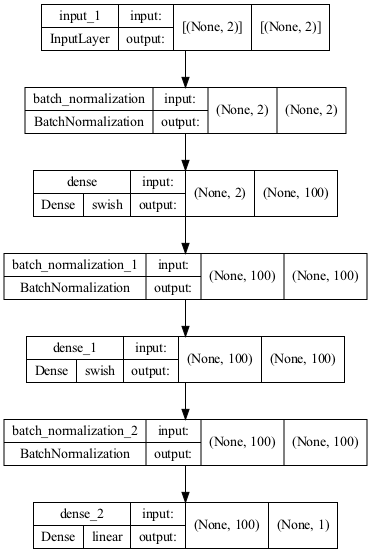

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

2022-06-27 13:21:58.414239: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: trained_models/bs/ffn/assets
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 2)           8           ['input_2[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 dense_3 (Dense)                (None, 100)          300         ['batch_normalization_3[0][0]']  
                                                                                                  
 batch_normalization_4 (Batc

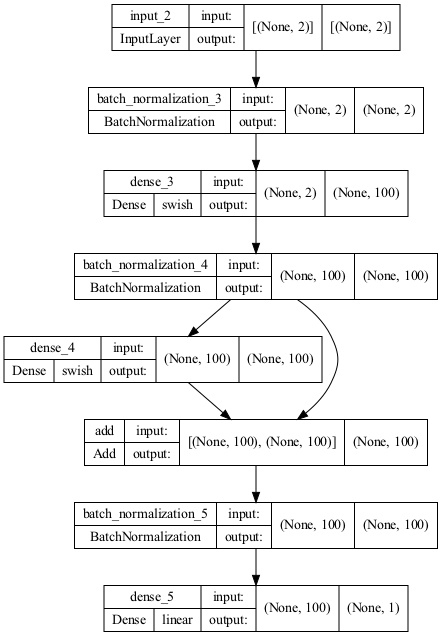

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

INFO:tensorflow:Assets written to: trained_models/bs/resnet/assets
Model: "differential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2)]               0         
                                                                 
 batch_normalization_6 (Batc  (None, 2)                8         
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 100)               300       
                                                                 
 batch_normalization_7 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 100)               10100     
                                               

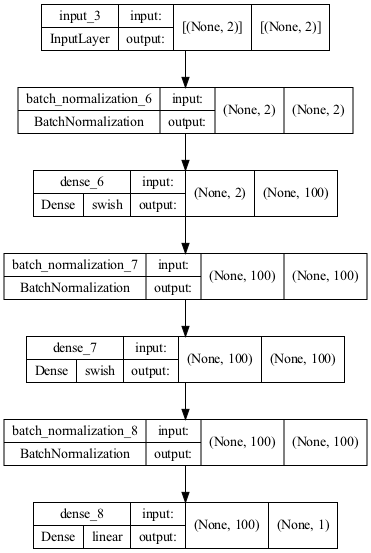

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

INFO:tensorflow:Assets written to: trained_models/bs/differential/assets
Model: "pde_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 batch_normalization_9 (Batc  (None, 2)                8         
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 100)               300       
                                                                 
 batch_normalization_10 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dense_10 (Dense)            (None, 100)               10100     
                                                

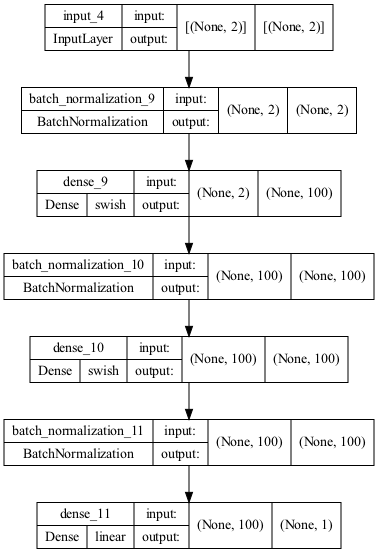

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 2), dtype=tf.float32, name='x_var'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x139218940>, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x139218a60>), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 2), dtype=tf.float32, name='x_var'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x139218940>, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x139218a60>), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 2), dtype=tf.float32, name='x_var'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x139336400>, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x139336430>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 2), dtype=tf.float32, name='x_var'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x139218940>, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x139218a60>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 2), dtype=tf.float32, name='x_var'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x139218940>, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x139218a60>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 2), dtype=tf.float32, name='x_var'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x139336400>, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x139336430>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 2), dtype=tf.float32, name='x_var'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x139336400>, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x139336430>), {}).


INFO:tensorflow:Assets written to: trained_models/bs/npde/assets


INFO:tensorflow:Assets written to: trained_models/bs/npde/assets


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 batch_normalization_12 (BatchN  (None, 2)           8           ['input_5[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 ttm (Dense)                    (None, 1)            3           ['batch_normalization_12[0][0]'] 
                                                                                                  
 moneyness (Dense)              (None, 1)            3           ['batch_normalization_12[0]

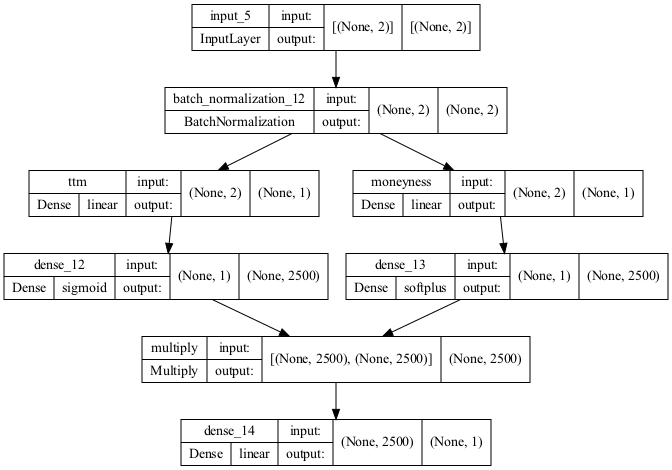

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

INFO:tensorflow:Assets written to: trained_models/bs/gated/assets


INFO:tensorflow:Assets written to: trained_models/bs/gated/assets


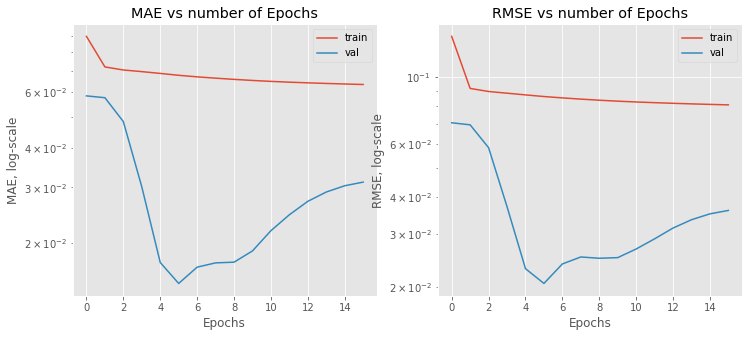

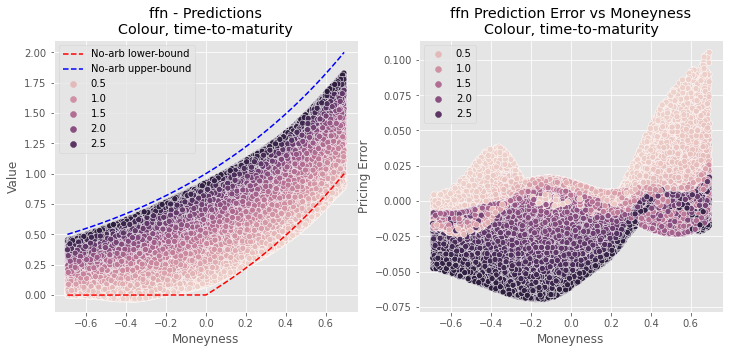

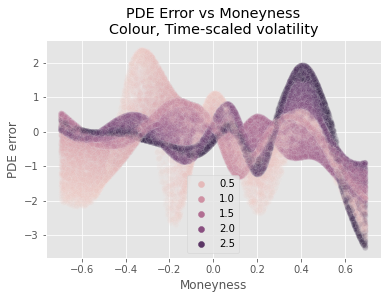

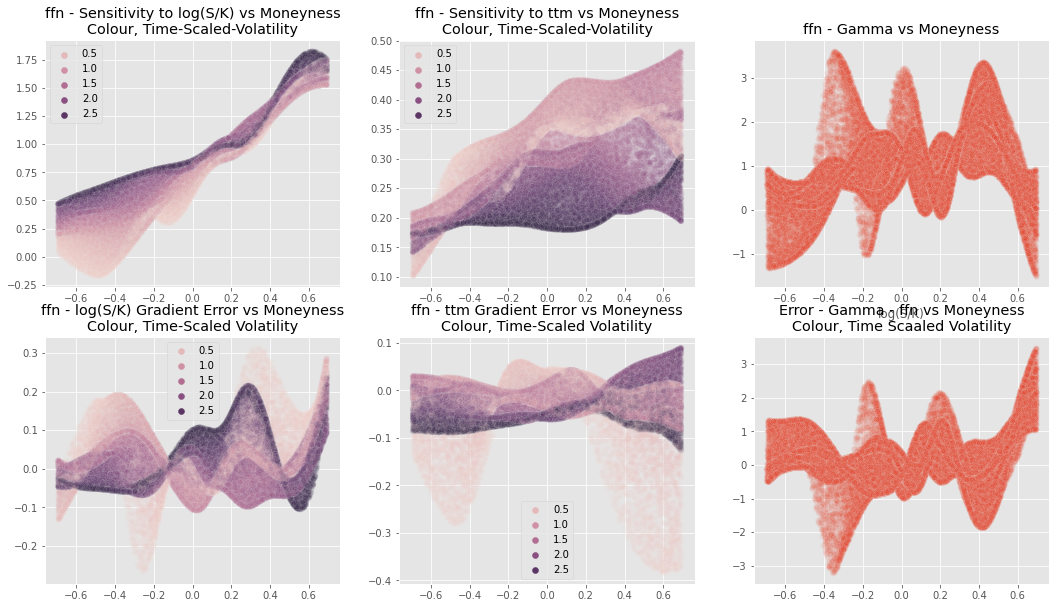

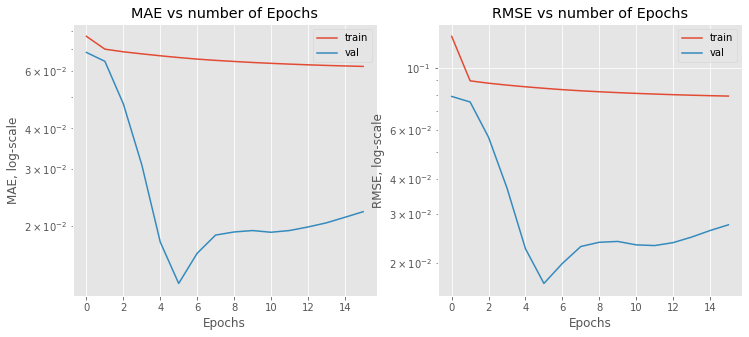

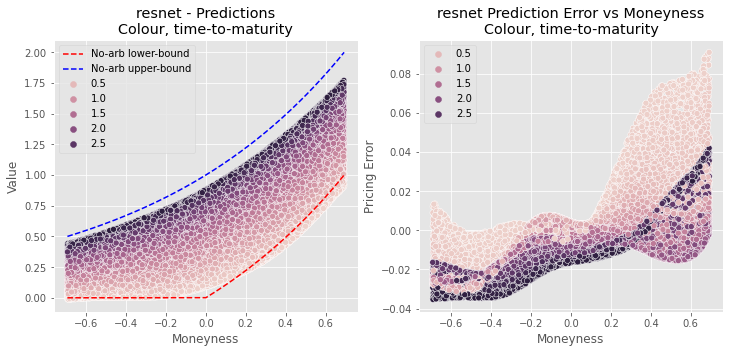

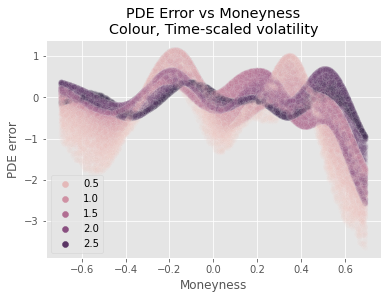

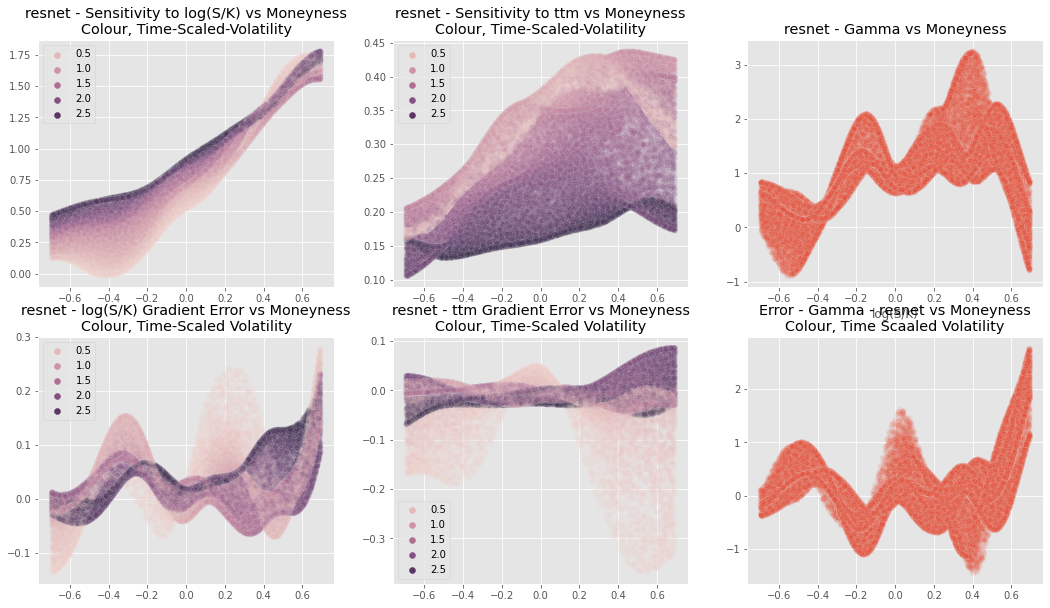

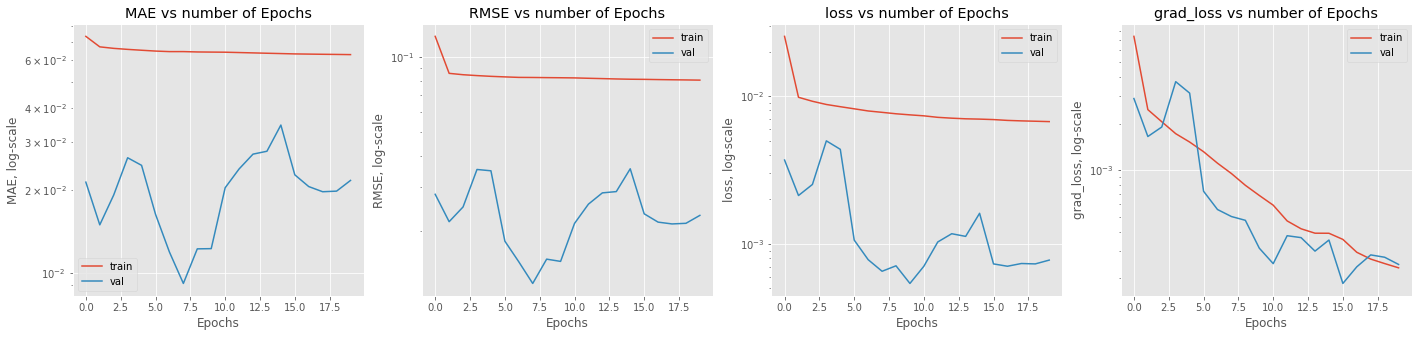

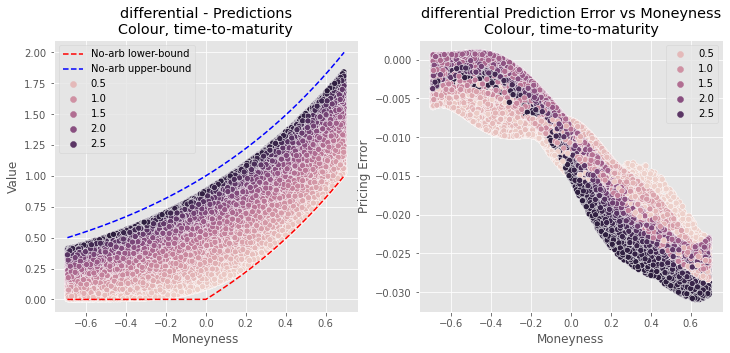

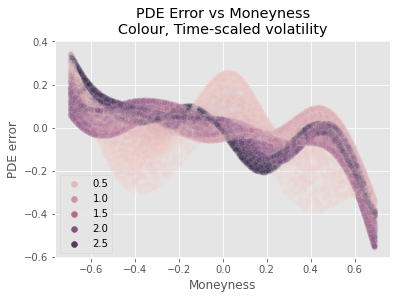

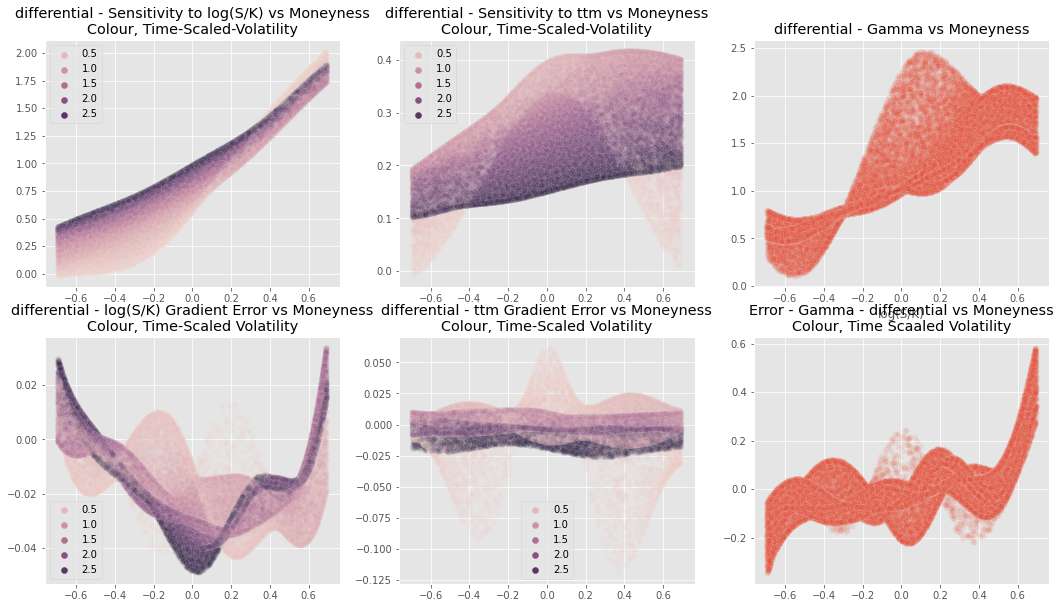

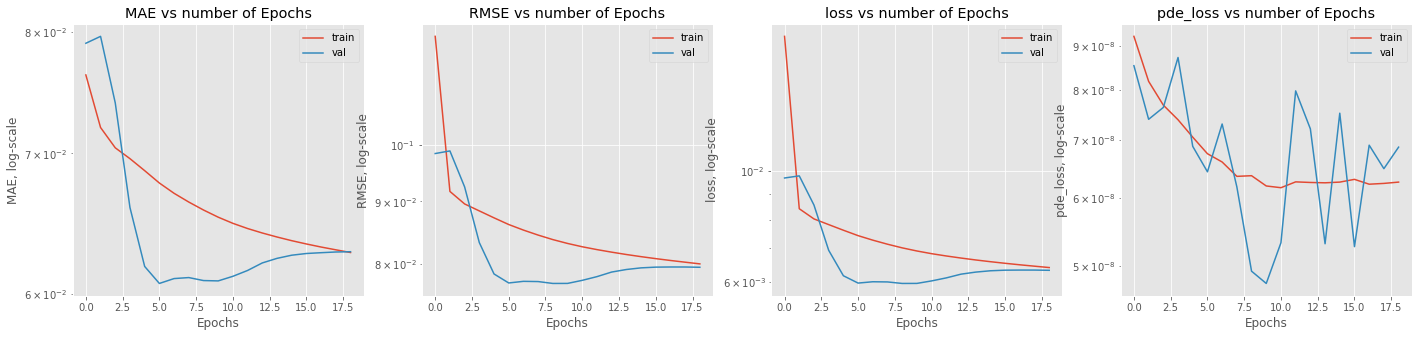

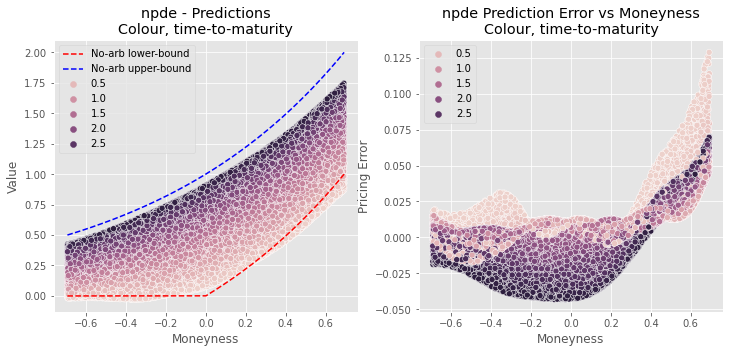

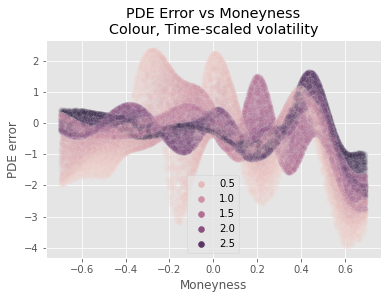

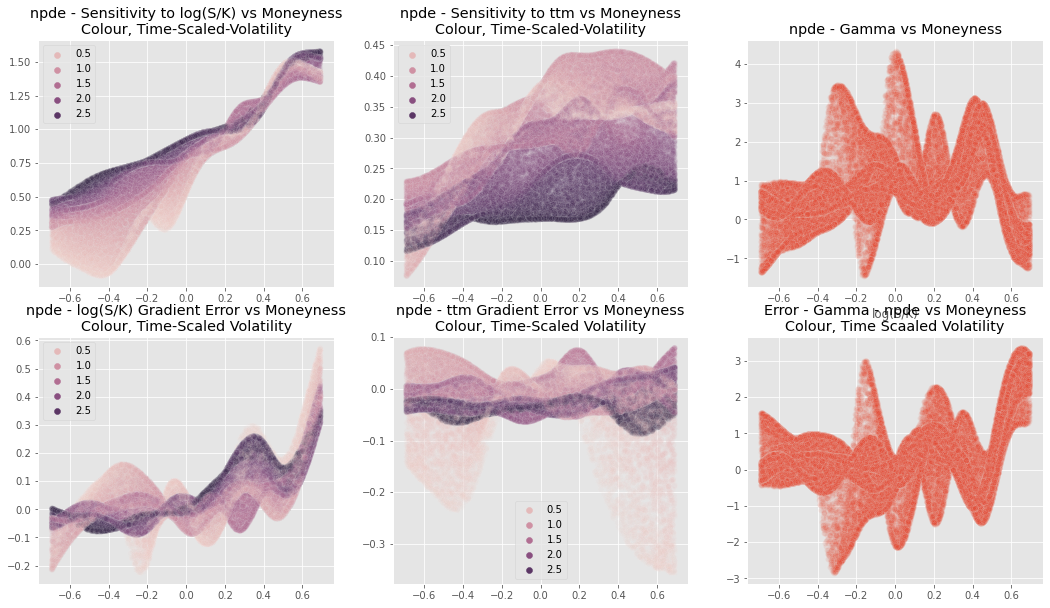

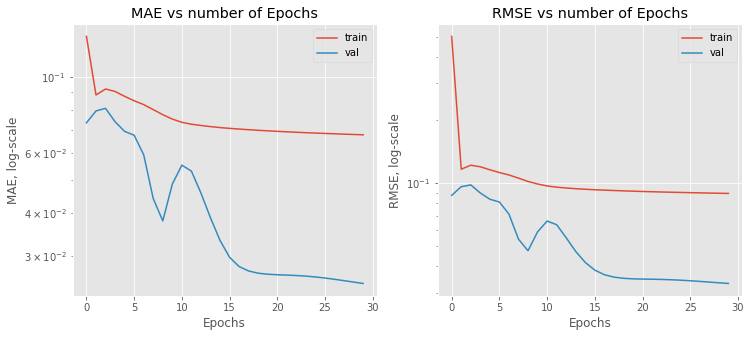

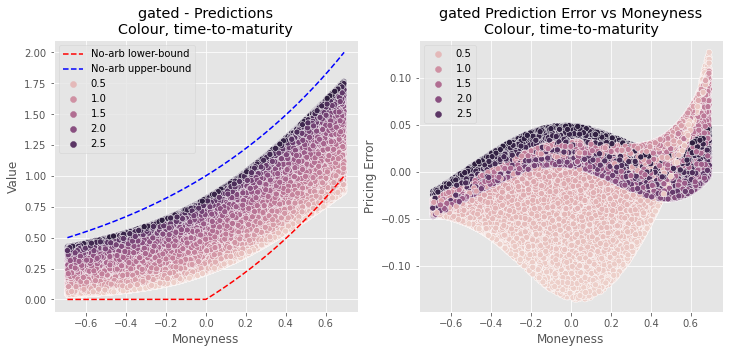

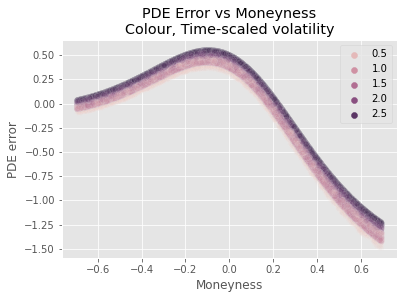

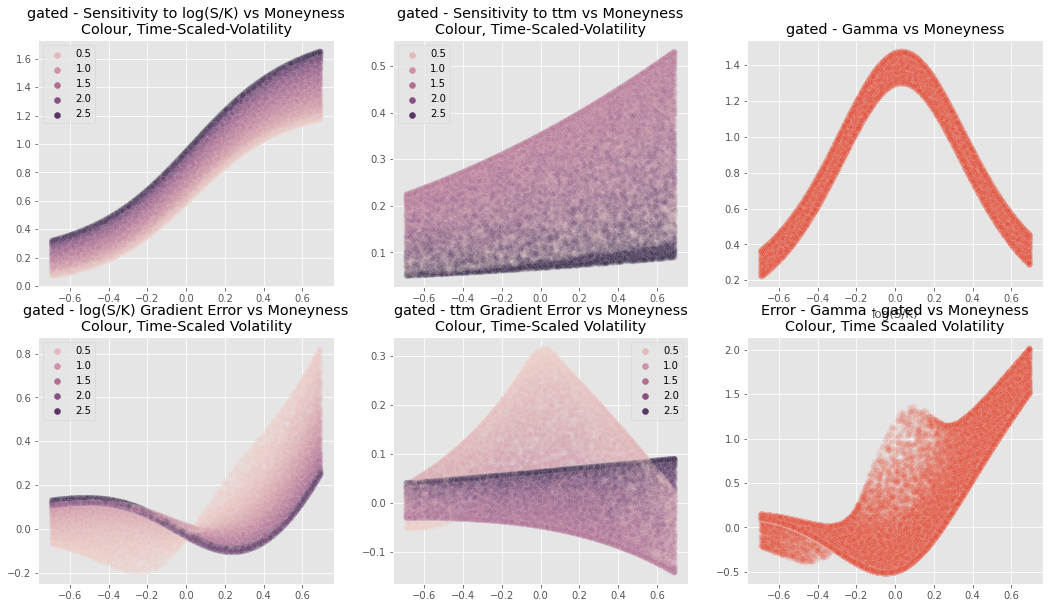

In [5]:
### define the neural network architecture
for METHOD in ["ffn", "resnet","differential", "npde","gated"]:
    metrics_to_add = []
    if METHOD == "differential":
        diff_model = make_model(**nn_params)
        all_models[METHOD] = DifferentialModel(diff_model.input, diff_model.output)
        all_models[METHOD].set_params(grad_loss_fn=tf.keras.losses.MeanSquaredError(), lam = 1.0)
        metrics_to_add  = ['loss','grad_loss']
    elif METHOD == "npde":
        pde_model = make_model(**nn_params)
        temp = PDEModel(pde_model.input, pde_model.output)
        all_models[METHOD] = PDEModel(pde_model.input, pde_model.output)
        all_models[METHOD].set_params(feat_names=['log(S/K)', 'ttm'], lam = 1.0, pde_loss=bs_nn_train_pde)
        metrics_to_add  = ['loss','pde_loss']
    elif METHOD == "gated":
        nn_params2 = nn_params.copy()
        nn_params2['hidden_units'] = (nn_params2['hidden_units'] ** 2) / 4
        for param in ['n_layers', 'hidden_act', 'output_act', 'dropout_ratio']:
            nn_params2.pop(param)
        all_models[METHOD] = homogeneity_network(**nn_params2)
        gated_network_instantiate(all_models[METHOD], f_to_i)
    elif METHOD == "resnet":
        nn_params2 = nn_params.copy()
        nn_params2['resnet'] = True
        all_models[METHOD] = make_model(**nn_params2)
    else:
        all_models[METHOD] = make_model(**nn_params)
        
    opt = Adam(learning_rate=ExponentialDecay(LR, decay_steps=2000,
        decay_rate=0.95,
    ))
    ### re-instantiate the optimizer, and compile the neural network
    all_models[METHOD].compile(optimizer=opt, **compile_params)
    ### summarize model
    all_models[METHOD].summary()
    display(tf.keras.utils.plot_model(
        all_models[METHOD], show_layer_activations=True, show_shapes=True, dpi=72
    ))
    #### Training
    try:
        #### try loading the model from disk
        all_models[METHOD] = tf.keras.models.load_model(f"trained_models/bs/{METHOD}")
        temp = bs_model_inference(
            all_models = all_models, 
            all_model_preds = all_model_preds, 
            METHOD = METHOD, 
            all_model_grads = all_model_grads, 
            all_model_hessian = all_model_hessian, 
            X_df_test = X_df_test, 
            Xs_test = Xs_test, 
            true = true, 
            true_grads = true_grads_test.values, 
            f_to_i = f_to_i, 
            intrinsic_val = intrinsic_val, 
            upper_bound = upper_bound)
    except:
        ### if not found, retrain
        if METHOD == "differential":
            train_time, history = train_nn(model = all_models[METHOD], 
                                           X = Xs_train, 
                                           ys = (ys_train, true_grads_train), 
                                           fit_params = fit_params, 
                                           metric_names + metrics_to_add)
        else:
            train_time, history = train_nn(model = all_models[METHOD], 
                                           X = Xs_train, 
                                           ys = ys_train, 
                                           fit_params = fit_params, 
                                           metric_names + metrics_to_add)
        all_models[METHOD].save(f"trained_models/bs/{METHOD}", save_format='tf')
        #### Inference
        temp = bs_model_inference(
            all_models = all_models, 
            all_model_preds = all_model_preds, 
            METHOD = METHOD, 
            all_model_grads = all_model_grads, 
            all_model_hessian = all_model_hessian, 
            X_df_test = X_df_test, 
            Xs_test = Xs_test, 
            true = true, 
            true_grads = true_grads_test.values, 
            f_to_i = f_to_i, 
            intrinsic_val = intrinsic_val, 
            upper_bound = upper_bound)
        temp["train_time"] = train_time
    all_res += [temp.copy()]

In [6]:
# # class PDEModel(tf.keras.Model):
# #     """
# #     Wrapper to enable differential training
# #     """
# #     def set_params(self, lam = 1.0, pde_loss = None, feat_names = []):
# #         self.lam = lam
# #         self.feat_names = feat_names
# #         self.pde_loss = pde_loss
# #         self.f_to_i = lambda x: feat_names.index(x)
# #         self.loss_tracker_pde = tf.keras.metrics.Mean(name="pde_loss")
# #         self.loss_tracker_pred = tf.keras.metrics.Mean(name="pred_loss")
# #         self.loss_tracker = tf.keras.metrics.Mean(name="loss")
# #     @tf.function
# #     def train_step(self, data):
# #         x_var, y = data
# #         # https://keras.io/guides/customizing_what_happens_in_fit/#going-lowerlevel
        
# #         with tf.GradientTape() as model_tape:      
# #             pde_loss, model_pred = self.pde_loss(x_var, self, self.f_to_i)
# #             pred_loss = tf.keras.losses.MeanSquaredError()(model_pred, y)
# #             loss = pred_loss + self.lam * pde_loss
                
# #         trainable_vars = self.trainable_variables
# #         model_grad = model_tape.gradient(loss, trainable_vars)
# #         self.optimizer.apply_gradients(zip(model_grad, trainable_vars))
# #         self.compiled_metrics.update_state(y, model_pred)
# #         self.loss_tracker.update_state(loss)
# #         self.loss_tracker_pde.update_state(pde_loss)
# #         self.loss_tracker_pred.update_state(pred_loss)
# #         metrics_to_ret = {m.name: m.result() for m in self.metrics}
# #         metrics_to_ret['loss'] = self.loss_tracker.result()
# #         metrics_to_ret['pred_loss'] = self.loss_tracker_pred.result()
# #         metrics_to_ret['pde_loss'] = self.loss_tracker_pde.result()
# #         return metrics_to_ret
    
# #     @tf.function
# #     def test_step(self, data):
# #         x_var, y = data
# #         # https://keras.io/guides/customizing_what_happens_in_fit/#going-lowerlevel
# #         with tf.GradientTape() as model_tape:      
# #             pde_loss, model_pred = self.pde_loss(x_var, self, self.f_to_i)
# #             pred_loss = tf.keras.losses.MeanSquaredError()(model_pred, y)
# #             loss = pred_loss + self.lam * pde_loss
# #         self.compiled_metrics.update_state(y, model_pred)
# #         self.loss_tracker.update_state(loss)
# #         self.loss_tracker_pde.update_state(pde_loss)
# #         self.loss_tracker_pred.update_state(pred_loss)
# #         metrics_to_ret = {f"{m.name}": m.result() for m in self.metrics}
# #         metrics_to_ret['loss'] = self.loss_tracker.result()
# #         metrics_to_ret['pred_loss'] = self.loss_tracker_pred.result()
# #         metrics_to_ret['pde_loss'] = self.loss_tracker_pde.result()
# #         return metrics_to_ret
    
# METHOD = "npde"
# pde_model = make_model(**nn_params)
# temp = PDEModel(pde_model.input, pde_model.output)
# all_models[METHOD] = PDEModel(pde_model.input, pde_model.output)
# @tf.function
# def bs_nn_train_pde(x_var, model, f_to_i):
#     with tf.GradientTape() as hessian_tape:
#         with tf.GradientTape() as grad_tape:
#             grad_tape.watch(x_var)
#             hessian_tape.watch(x_var)
#             model_pred = model(x_var, training = True)
#             gradients = grad_tape.gradient(model_pred, x_var)
#             hessian = hessian_tape.gradient(gradients[:, f_to_i("log(S/K)")], x_var)
#     pde_loss = tf.keras.losses.MeanAbsoluteError()(gradients[:, f_to_i("ttm")] / x_var[:, f_to_i("ttm")], 
#                             hessian[:, f_to_i("log(S/K)")] - gradients[:, f_to_i("log(S/K)")])
#     return pde_loss, model_pred
# all_models[METHOD].set_params(lam = 10000.0, feat_names=['log(S/K)', 'ttm'], pde_loss=bs_nn_train_pde)
# metrics_to_add  = ['loss','pde_loss']


# opt = Adam(learning_rate=ExponentialDecay(LR, decay_steps=2000,
#     decay_rate=0.95,
# ))
# ### re-instantiate the optimizer, and compile the neural network
# all_models[METHOD].compile(optimizer=opt, **compile_params)
# train_time, history = train_nn(all_models[METHOD], 
#                                            Xs_train, 
#                                            ys_train, 
#                                            fit_params, 
#                                            metric_names + metrics_to_add)



# temp = bs_model_inference(all_models, all_model_preds, METHOD, all_model_grads, all_model_hessian, X_df_test, Xs_test, true, f_to_i, intrinsic_val, upper_bound)
# temp["train_time"] = train_time
# all_res += [temp.copy()]

In [7]:
# temp = bs_model_inference(all_models, all_model_preds, METHOD, all_model_grads, all_model_hessian, X_df, Xs_train, X_df['call_true'].values, f_to_i, intrinsic_val = np.exp(X_df['log(S/K)']) - 1.0, upper_bound = np.exp(X_df['log(S/K)']))
# temp["train_time"] = train_time
# all_res += [temp.copy()]

## Ensemble

In [20]:
del all_model_preds['poly_reg']

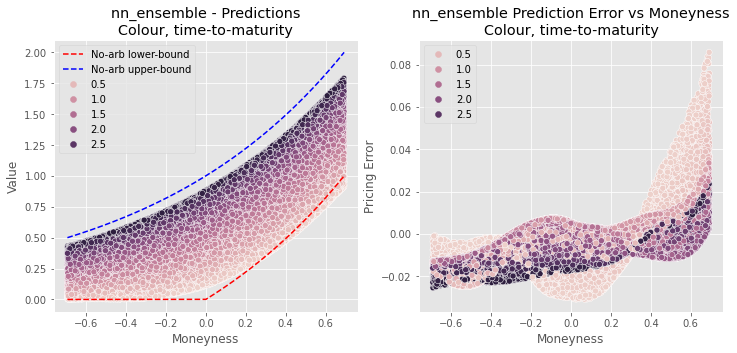

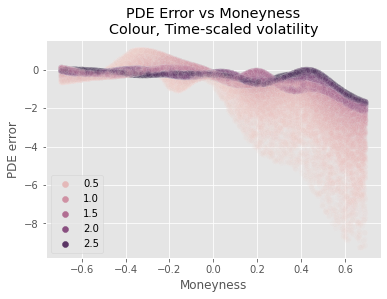

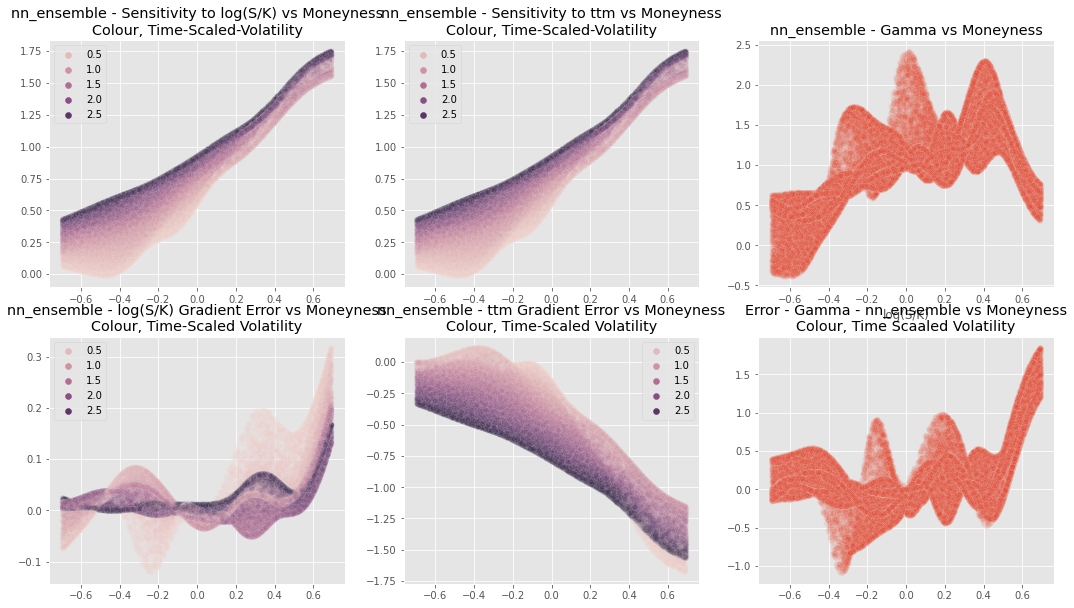

In [21]:
ensemble_preds = pd.DataFrame(all_model_preds).mean(axis=1).values
ensemble_hessian = pd.DataFrame({x:all_model_hessian[x][:,0] for x in all_model_hessian}).mean(axis = 1).values.reshape((-1, 1))
ensemble_grads = np.zeros((X_df_test.shape[0], N_FEATS))
for i in range(N_FEATS):
    ensemble_grads[:, i] =pd.DataFrame({x:all_model_grads[x][:,0] for x in all_model_grads}).mean(axis = 1).values
METHOD = "nn_ensemble"
temp = bs_eval_wrapper(
    X_df_test,
    true_val=true,
    preds=ensemble_preds,
    grads=ensemble_grads,
    hessian_moneyness=ensemble_hessian,
    lower_bound=intrinsic_val,
    upper_bound=upper_bound,
    true_grads = true_grads_test.values,
    METHOD=METHOD,
)

all_res += [temp.copy()]

## Polynomial

13


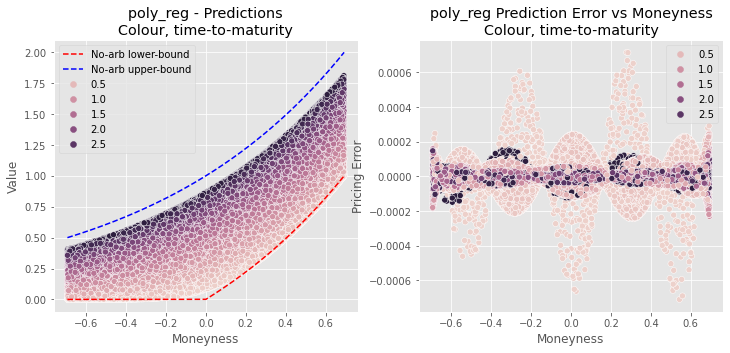

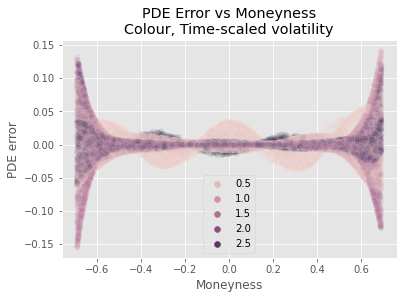

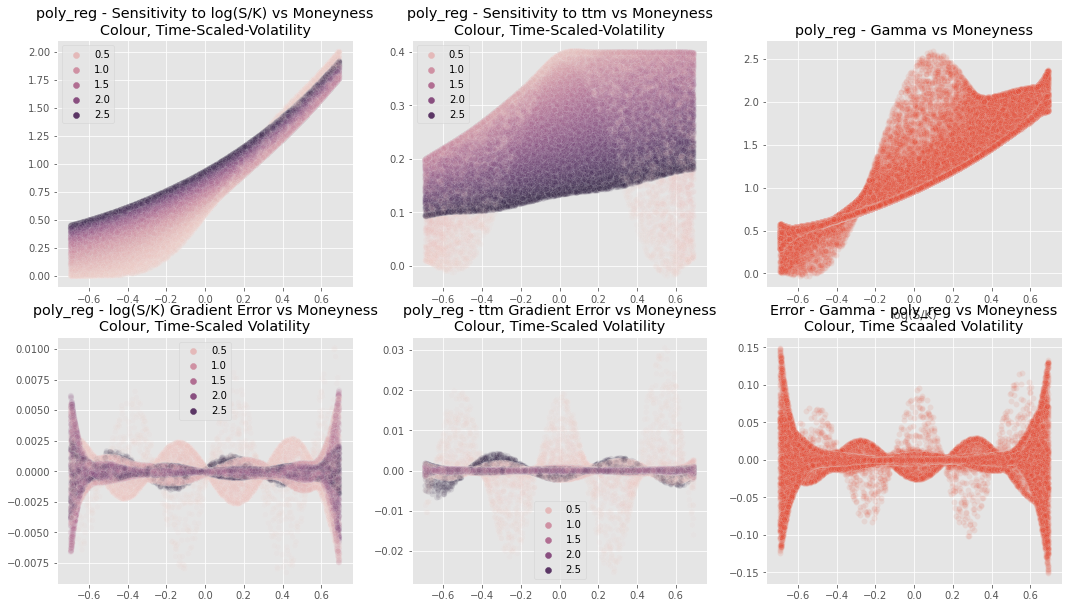

In [39]:
from nn_option_pricer.poly_reg import train_infer_poly
import math

METHOD = "poly_reg"
start = time.time()
degree = round((math.factorial(N_FEATS) * (nn_params["hidden_units"])) ** (1/ N_FEATS) - 1)
print(degree)
# spline = SplineTransformer(n_knots=5, degree=10, knots="uniform", extrapolation="linear")
train_time, inference_time = train_infer_poly(degree, Xs_train, ys_train, Xs_test, ys_test, feat_names, all_models, all_model_preds, all_model_grads, all_model_hessian, f_to_i, moneyness_var="log(S/K)", METHOD="poly_reg", eps=1e-4)

temp = bs_eval_wrapper(
    X_df_test,
    true_val=true,
    preds=all_model_preds[METHOD],
    grads=all_model_grads[METHOD],
    hessian_moneyness=all_model_hessian[METHOD],
    lower_bound=intrinsic_val,
    upper_bound=upper_bound,
    true_grads = true_grads_test.values,
    METHOD="poly_reg",
)

temp['train_time'] = train_time
temp["model_parameters"] = len(all_models[METHOD]['lr'].coef_)
temp['inference_time'] = inference_time
all_res += [temp.copy()]

In [57]:
all_res_df.to_latex?

Signature:
all_res_df.to_latex(
    buf=None,
    columns=None,
    col_space=None,
    header=True,
    index=True,
    na_rep='NaN',
    formatters=None,
    float_format=None,
    sparsify=None,
    index_names=True,
    bold_rows=False,
    column_format=None,
    longtable=None,
    escape=None,
    encoding=None,
    decimal='.',
    multicolumn=None,
    multicolumn_format=None,
    multirow=None,
    caption=None,
    label=None,
    position=None,
)
Docstring:
Render object to a LaTeX tabular, longtable, or nested table/tabular.

Requires ``\usepackage{booktabs}``.  The output can be copy/pasted
into a main LaTeX document or read from an external file
with ``\input{table.tex}``.

.. versionchanged:: 1.0.0
   Added caption and label arguments.

.. versionchanged:: 1.2.0
   Added position argument, changed meaning of caption argument.

Parameters
----------
buf : str, Path or StringIO-like, optional, default None
    Buffer to write to. If None, the output is returned as a strin

In [40]:
all_res_df = (
    pd.concat(all_res)
    .reset_index()
    .drop_duplicates(subset=["index"], keep="last")
    .set_index("index")
    .T)
# )
# all_res_df = all_res_df.drop('poly_reg', axis = 1)
print(all_res_df.to_latex(float_format="%.4f"))
display(all_res_df.style.background_gradient(axis=1))
all_res_df.to_csv("bs_results_table.csv", index= False)

\begin{tabular}{lrrrrrrr}
\toprule
index &           ffn &        resnet &  differential &          npde &         gated &  nn\_ensemble &    poly\_reg \\
\midrule
pred\_l1                    &      0.015131 &      0.013450 &      0.012139 &      0.014868 &      0.024755 &     0.009778 &    0.000032 \\
pred\_l2                    &      0.020882 &      0.017089 &      0.014927 &      0.020297 &      0.033077 &     0.012151 &    0.000053 \\
pred\_l\_inf                 &      0.105274 &      0.090931 &      0.030946 &      0.128729 &      0.135726 &     0.085757 &    0.000715 \\
pred\_lower\_bound\_violation &      0.029449 &      0.024094 &      0.000000 &      0.031448 &      0.016205 &     0.015091 &    0.000366 \\
pred\_upper\_bound\_violation &      0.000000 &      0.000000 &      0.000000 &      0.000000 &      0.000000 &     0.000000 &    0.000000 \\
PDE\_mean                   &      0.190876 &      0.154337 &      0.020385 &      0.327979 &      0.101920 &     0.616222 &    0.0

# Calibration

In [ ]:
y_tensor = tf.Variable(ys_test.reshape((-1, 1)).astype(np.float32))
init_tensor = Xs_test.copy()
init_tensor[:, 1] = 1.0
init_tensor = tf.Variable(init_tensor)
vec = np.zeros((1, 2))
vec[:, 1] = 1.0
start = time.time()
calibration_error = []

# opt = tf.keras.optimizers.Adam(learning_rate=0.1)

with tf.GradientTape() as y_tape:
    y_tape.watch(y_tensor)
    for i in tqdm(range(50)):
        with tf.GradientTape() as tape:
            tape.watch(init_tensor)
            error  = (y_tensor - all_models["ffn"](init_tensor)) ** 2
            grad = tape.gradient(error, init_tensor)
        init_tensor = init_tensor - grad * vec
    y_grad = y_tape.batch_jacobian(init_tensor, y_tensor)
cal_time = time.time() - start

In [ ]:
errors = error.numpy()

In [ ]:
fig, ax = plt.subplots()
sns.histplot(errors, bins = 50, ax = ax)
ax.set_xscale("log")

In [ ]:
cal_error = (Xs_test - init_tensor)[:,1].numpy()
sns.histplot(cal_error)

In [ ]:
sns.scatterplot(Xs_test[:,0], y_grad[:, 1, :].numpy().reshape(-1), hue = ys_test)

In [ ]:
sns.scatterplot(ys_test, y_grad[:, 1, :].numpy().reshape(-1), hue = Xs_test[:,1])

# Hedge Analysis

In [ ]:
# preds = model.predict(Xs).reshape(-1)
# X_tensor = tf.Variable(Xs)
# with tf.GradientTape() as tape:
#     output = model(X_tensor)
#     grads = tape.gradient(output, X_tensor)

# delta = grads[:,0].numpy().reshape((-1, 32))
# St = X_df['log(S/K)'].values.reshape((2048, -1))
# payoff = X_df.groupby('path')['call_payoff'].mean().values
# hedge_pnl = preds[::32] + np.sum(delta[:, :-1] * np.diff(St, axis = 1), axis = 1) - payoff

# sns.histplot(hedge_pnl)